In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,classification_report

from sklearn.utils import resample 
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE,SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV,train_test_split

In [2]:
df = pd.read_excel('default_of_credit_card_clients_0.xlsx')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.drop(columns=["ID"], inplace = True)
df.rename(columns={'default payment next month': "Default_Pay"}, inplace = True)

In [4]:
df.rename(columns={'PAY_0':'Rpay_status_1','PAY_2':'Rpay_status_2','PAY_3':'Rpay_status_3','PAY_4':'Rpay_status_4',
                   'PAY_5':'Rpay_status_5','PAY_6':'Rpay_status_6'},inplace = True)
df.rename(columns={'BILL_AMT1':'Statement_1','BILL_AMT2':'Statement_2','BILL_AMT3':'Statement_3',
                   'BILL_AMT4':'Statement_4','BILL_AMT5':'Statement_5','BILL_AMT6':'Statement_6'},inplace = True)
df.rename(columns={'PAY_AMT1':'Payment_1','PAY_AMT2':'Payment_2','PAY_AMT3':'Payment_3',
                  'PAY_AMT4':'Payment_4','PAY_AMT5':'Payment_5','PAY_AMT6':'Payment_6'},inplace = True)
df.rename(columns={'SEX':'Gender','MARRIAGE':'MaritalStatus','EDUCATION':'Education'},inplace = True)

In [5]:
df['Education'] = df['Education'].replace([5,6,0], 4)
df['Education'].unique()

array([2, 1, 3, 4], dtype=int64)

In [6]:
df['MaritalStatus'] = df['MaritalStatus'].replace(0,3)
df['MaritalStatus'].unique()

array([1, 2, 3], dtype=int64)

In [7]:
df[['Gender','MaritalStatus','Education']] = df[['Gender','MaritalStatus','Education']].astype('object')

df = pd.get_dummies(df)
df.head()

,LIMIT_BAL,AGE,Rpay_status_1,Rpay_status_2,Rpay_status_3,Rpay_status_4,Rpay_status_5,Rpay_status_6,Statement_1,Statement_2,...,Default_Pay,Gender_1,Gender_2,Education_1,Education_2,Education_3,Education_4,MaritalStatus_1,MaritalStatus_2,MaritalStatus_3
0,20000,24,2,2,0,0,0,0,3913,3102,...,1,0,1,0,1,0,0,1,0,0
1,120000,26,0,2,0,0,0,2,2682,1725,...,1,0,1,0,1,0,0,0,1,0
2,90000,34,0,0,0,0,0,0,29239,14027,...,0,0,1,0,1,0,0,0,1,0
3,50000,37,0,0,0,0,0,0,46990,48233,...,0,0,1,0,1,0,0,1,0,0
4,50000,57,0,0,0,0,0,0,8617,5670,...,0,1,0,0,1,0,0,1,0,0


In [8]:
df.rename(columns = {'Gender_2':'Gender_Male','Gender_2':'Gender_Female',
                     'Education_1':'Education_Graduate','Education_2':'Education_University',
                     'Education_3':'Education_HighSchool','Education_4':'Education_Others',
                     'MaritalStatus_1':'MaritalStatus_Married',
                     'MaritalStatus_2':'MaritalStatus_Single',
                     'MaritalStatus_3':'MaritalStatus_Others'},inplace=True)

In [9]:
X =df.drop(['Default_Pay'], axis=1)
y = df['Default_Pay']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=123)

In [10]:
df_SMOTE = SMOTE(random_state=12)
X_SMOTE, y_SMOTE = df_SMOTE.fit_resample(X_train, y_train)

print('Total:',len(y_SMOTE))
print('Default count:',y_SMOTE.sum())
print('Non-Default count:', len(y_SMOTE)-y_SMOTE.sum())

Total: 37382
Default count: 18691
Non-Default count: 18691


In [11]:
def Eval_model(clf, X_train,y_train,X_test,y_test):

    clf.fit(X_train,y_train)
    
    y_predict = clf.predict(X_train)
    y_train_probability = clf.predict_proba(X_train)[:,1]

    print('Train Data Accuracy',accuracy_score(y_train,y_predict))
    print('Train Data AUC Score',roc_auc_score(y_train,y_train_probability))
    

    y_test_predict = clf.predict(X_test)
    y_test_probability = clf.predict_proba(X_test)[:,1]


    print('Test Data Accuracy',accuracy_score(y_test,y_test_predict))
    print('Test Data AUC Score',roc_auc_score(y_test,y_test_probability))
    
    print('Test Classification Report\n',  classification_report(y_test, y_test_predict))
    
    kf = KFold(n_splits = 5,shuffle = True,random_state = 123)
    score=[]
    for train_idx,test_idx in kf.split(X_train,y_train):
        x_train_kf,x_test_kf = X_train.iloc[train_idx,:],X_train.iloc[test_idx,:]
        y_train_kf,y_test_kf = y_train.iloc[train_idx],y_train.iloc[test_idx]
        
        clf.fit(x_train_kf,y_train_kf)
        y_predict_kf = clf.predict(x_test_kf)
        roc = roc_auc_score(y_test_kf,y_predict_kf)
        score.append(roc)
        
    print('K-Fold scores: %0.03f (+/- %0.5f)' % (np.mean(score),np.var(score,ddof=1)))
    
    f,ax =  plt.subplots(1,2,figsize=(15,5))
    
    Cf_Matrix = confusion_matrix(y_test,y_test_predict)
    sns.heatmap(Cf_Matrix,annot=True, cmap='YlGnBu', fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'],linewidths=.5,ax = ax[0])
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predict label')
    ax[0].set_title('Confusion_Matrix')

    global fpr,tpr,thresholds
    fpr,tpr,thresholds = roc_curve(y_test,y_test_probability)
    ax[1].plot(fpr,tpr,color = 'blue')
    ax[1].plot(fpr,fpr,color = 'pink')
    ax[1].set_ylabel('TPR')
    ax[1].set_xlabel('FPR')
    ax[1].set_title('ROC Curve')
    
    plt.show()

In [12]:
X_train = X_SMOTE
y_train = y_SMOTE

Randfc_clf = RandomForestClassifier()
    
    
params_dist = {'n_estimators' : randint(50,200),
               'max_features' : randint(1,24),
               'max_depth': randint(2,10),
               'min_samples_leaf':randint(1,20),
               'min_samples_split':randint(2,20),
               'criterion':['gini','entropy']}

    
Randfc_cv = RandomizedSearchCV(estimator = Randfc_clf, 
                               param_distributions= params_dist, 
                               cv = 5,
                               scoring = 'roc_auc',
                               n_iter = 150,
                               n_jobs = -1,
                               random_state = 1234,
                               return_train_score = True)
    
    
Randfc_cv.fit(X_train,y_train)
print("Tuned Random Forest Parameters: {}".format(Randfc_cv.best_params_)) 

Tuned Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 19, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 109}


In [15]:
parameters = {'criterion': 'entropy', 'max_depth': 9, 'max_features': 19, 
              'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 109}

Train Data Accuracy 0.8623134128725055
Train Data AUC Score 0.9346173152916144
Test Data Accuracy 0.8143333333333334
Test Data AUC Score 0.7717857125003084
Test Classification Report
               precision    recall  f1-score   support

           0       0.85      0.92      0.89      4673
           1       0.61      0.45      0.52      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.68      0.70      6000
weighted avg       0.80      0.81      0.80      6000

K-Fold scores: 0.850 (+/- 0.00001)


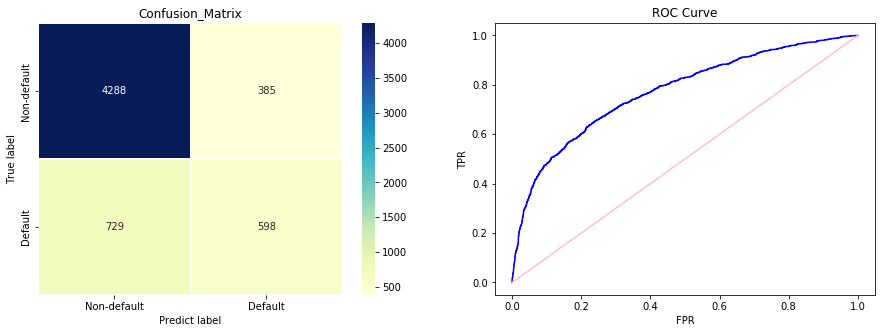

In [16]:
Eval_model(RandomForestClassifier(**parameters,random_state= 555), X_train,y_train,X_test,y_test)

In [17]:
import pickle

# open a file, where to store data
file = open('random_forest_classifier_model.pkl', 'wb')

# dump info to the file
pickle.dump(Randfc_cv, file)